In [2]:
#lets start with some imports

import importlib

#Py-ART, simply the best sowftware around.. Give those guys a grant
import cartopy
import pyart
#timezone info
import pytz

#plotting
from matplotlib import pyplot as plt

#plotting on a maop

import operator

import xarray as xr
import netCDF4

import scipy.ndimage as ndimage

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np
from cmac import cmac, quicklooks, get_sounding_times, get_sounding_file_name, config, cmac_processing
import copy
import matplotlib.colors as mc
import matplotlib.ticker as mt
import matplotlib.font_manager as fm
%matplotlib inline



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [3]:
import os
import datetime as dt

In [4]:
meta_config = config.get_metadata('cacti_csapr2_ppi')
cmac_config = config.get_cmac_values('cacti_csapr2_ppi')
field_config = config.get_field_names('cacti_csapr2_ppi')


temp_field = field_config['temperature']
alt_field = field_config['altitude']
vel_field = field_config['velocity']

#field_config['reflectivity'] = 'uncorrected_reflectivity_h'
#field_config['phidp'] = 'uncorrected_differential_phase'

ref_offset = cmac_config['ref_offset']
self_const = cmac_config['self_const']

In [5]:
verbose = True
sweep = 2

In [18]:
#soundings_directory = '/data/CACTI/sonde/'
#radar_directory = '/data/CACTI/csapr2/'

#on bebop 
# soundings_directory = '/home/icrisologo/Data/CACTI/sonde/'
# radar_directory = '/lcrc/group/earthscience/radar/CACTI/PPI/'

# on STRATUS
radar_directory = '/lustre/or-hydra/cades-arm/proj-shared/corcsapr2cfrppiM1.a1/201902/'
soundings_directory = '/lustre/or-hydra/cades-arm/proj-shared/corsondewnpnM1.b1/'

In [7]:
inf = 'corcsapr2cfrppiM1.a1.20190124.200003.nc'
#inf2 = 'corcsapr2cfrppiM1.a1.20181105.191503.nc'
radar = pyart.io.read(radar_directory + inf)


In [8]:
ncf_sounding = netCDF4.Dataset(soundings_directory + 'corsondewnpnM1.b1.20190124.210000.cdf')

In [9]:
if 'gen_clutter_from_refl' not in cmac_config.keys():
    cmac_config['gen_clutter_from_refl'] = False

if cmac_config['gen_clutter_from_refl']:
    new_clutter_field = cmac_processing.gen_clutter_field_from_refl(radar, 
                                                                    field_config['input_clutter_corrected_reflectivity'],
                                                                    field_config['reflectivity'],
                                                                    diff_dbz=cmac_config['gen_clutter_from_refl_diff'], 
                                                                    max_h=cmac_config['gen_clutter_from_refl_alt'])
    radar.add_field(field_config['clutter'], new_clutter_field, replace_existing=True)
                                 
                                 

In [10]:
rlat = radar.latitude['data'][0]
rlon = radar.longitude['data'][0]


#Get the date at the start of collection
index_at_start = radar.sweep_start_ray_index['data'][sweep]
time_at_start_of_radar = pyart.io.cfradial.netCDF4.num2date(radar.time['data'][index_at_start], 
                                  radar.time['units'])

#make a nice time stamp
pacific = pytz.timezone('America/Cordoba')
local_time = pacific.fromutc(time_at_start_of_radar)
fancy_date_string = '%.1f' % radar.fixed_angle['data'][sweep] + ' Degree sweep ' +local_time.strftime('%A %B %d at %I:%M %p GMT%Z')
print(fancy_date_string)

2.6 Degree sweep Thursday January 24 at 05:00 PM GMT-03


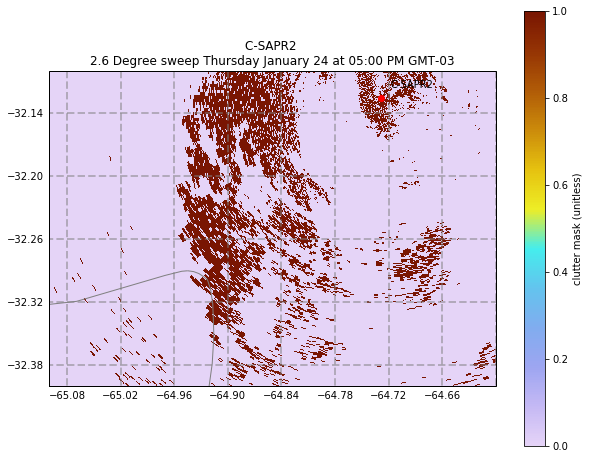

In [11]:
#Set up our figure
fig = plt.figure(figsize = [10,8])

#create a Cartopy Py-ART display object
display = pyart.graph.RadarMapDisplay(radar)

#get center of the display for the projection
lat_0 = rlat
lon_0 = rlon*-1

# Main difference from Basemap! 
#Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=rlat-5., max_latitude=rlat+5.)

title = 'C-SAPR2 \n' + fancy_date_string

#plot a PPI! add coastline at 10m resolution
display.plot_ppi_map(
    'ground_clutter', sweep, colorbar_flag=True,
    title=title,
    projection=projection, resolution='10m', 
    cmap=pyart.graph.cm.LangRainbow12,
    vmin=0, vmax=1, min_lon=-65.1, 
    min_lat=-32.4, max_lon=-64.6, max_lat=-32.1 )

# Mark the radar
display.plot_point(lon_0*-1, lat_0, label_text='C-SAPR2')

# Plot some lat and lon lines
gl = display.ax.gridlines(draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

## LOOP

In [12]:
rad_files = os.listdir(radar_directory)

In [13]:
rad_file = rad_files[0]

In [14]:
# clutter_savedirectory = '/lcrc/group/earthscience/icrisologo/cmac/clutter' # on bebop
clutter_savedirectory = '/lustre/or-hydra/cades-arm/proj-shared/irene/cmac/clutter' # on stratus

In [15]:
rad_files.sort()

In [16]:
len(rad_files)

896

In [17]:
for i in range(0,len(rad_files)):
    print(i,rad_files[i])
    rad_file = rad_files[i]
    radar = pyart.io.read(radar_directory + rad_file)

    if 'gen_clutter_from_refl' not in cmac_config.keys():
        cmac_config['gen_clutter_from_refl'] = False

    if cmac_config['gen_clutter_from_refl']:
        new_clutter_field = cmac_processing.gen_clutter_field_from_refl(radar, 
                                                                        field_config['input_clutter_corrected_reflectivity'],
                                                                        field_config['reflectivity'],
                                                                        diff_dbz=cmac_config['gen_clutter_from_refl_diff'], 
                                                                        max_h=cmac_config['gen_clutter_from_refl_alt'])
        radar.add_field(field_config['clutter'], new_clutter_field, replace_existing=True)

    radar.fields = {}
    radar.add_field(field_config['clutter'], new_clutter_field, replace_existing=True)

    savefname = 'clutter_'+rad_file
    pyart.io.write_cfradial(os.path.join(clutter_savedirectory,savefname), radar)

660 corcsapr2cfrppiM1.a1.20190128.231503.nc
661 corcsapr2cfrppiM1.a1.20190128.233003.nc
662 corcsapr2cfrppiM1.a1.20190128.234503.nc
663 corcsapr2cfrppiM1.a1.20190129.000003.nc
664 corcsapr2cfrppiM1.a1.20190129.001503.nc
665 corcsapr2cfrppiM1.a1.20190129.003003.nc
666 corcsapr2cfrppiM1.a1.20190129.004503.nc
667 corcsapr2cfrppiM1.a1.20190129.010003.nc
668 corcsapr2cfrppiM1.a1.20190129.011503.nc
669 corcsapr2cfrppiM1.a1.20190129.013003.nc
670 corcsapr2cfrppiM1.a1.20190129.014503.nc
671 corcsapr2cfrppiM1.a1.20190129.020003.nc
672 corcsapr2cfrppiM1.a1.20190129.021503.nc
673 corcsapr2cfrppiM1.a1.20190129.023003.nc
674 corcsapr2cfrppiM1.a1.20190129.024503.nc
675 corcsapr2cfrppiM1.a1.20190129.030003.nc
676 corcsapr2cfrppiM1.a1.20190129.031503.nc
677 corcsapr2cfrppiM1.a1.20190129.033003.nc
678 corcsapr2cfrppiM1.a1.20190129.034503.nc
679 corcsapr2cfrppiM1.a1.20190129.040003.nc
680 corcsapr2cfrppiM1.a1.20190129.041503.nc
681 corcsapr2cfrppiM1.a1.20190129.043003.nc
682 corcsapr2cfrppiM1.a1.2019012

847 corcsapr2cfrppiM1.a1.20190131.114503.nc
848 corcsapr2cfrppiM1.a1.20190131.120003.nc
849 corcsapr2cfrppiM1.a1.20190131.121503.nc
850 corcsapr2cfrppiM1.a1.20190131.123003.nc
851 corcsapr2cfrppiM1.a1.20190131.124503.nc
852 corcsapr2cfrppiM1.a1.20190131.130003.nc
853 corcsapr2cfrppiM1.a1.20190131.131503.nc
854 corcsapr2cfrppiM1.a1.20190131.133003.nc
855 corcsapr2cfrppiM1.a1.20190131.134503.nc
856 corcsapr2cfrppiM1.a1.20190131.140003.nc
857 corcsapr2cfrppiM1.a1.20190131.141503.nc
858 corcsapr2cfrppiM1.a1.20190131.143003.nc
859 corcsapr2cfrppiM1.a1.20190131.144503.nc
860 corcsapr2cfrppiM1.a1.20190131.150003.nc
861 corcsapr2cfrppiM1.a1.20190131.151503.nc
862 corcsapr2cfrppiM1.a1.20190131.153003.nc
863 corcsapr2cfrppiM1.a1.20190131.154503.nc
864 corcsapr2cfrppiM1.a1.20190131.160003.nc
865 corcsapr2cfrppiM1.a1.20190131.161503.nc
866 corcsapr2cfrppiM1.a1.20190131.163003.nc
867 corcsapr2cfrppiM1.a1.20190131.164503.nc
868 corcsapr2cfrppiM1.a1.20190131.170003.nc
869 corcsapr2cfrppiM1.a1.2019013